# Discretization Classification 2.0(Template) - KFold
## Author: Ming

In [1]:
#Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.calibration import CalibratedClassifierCV

#Discretization
from mdlp.discretization import MDLP
from caimcaim import CAIMD
from scorecardbundle.feature_discretization import ChiMerge as cm
from reportgen import preprocessing #Chimerge


from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, confusion_matrix

from threading import Thread, Lock


#Import Our Class
%run "TEJ Classification Package.ipynb"

## Import Data

In [2]:
# Load Data
data_name = "USA_Bankrupt"
# data_name = "Australian_Original"

if data_name == "Tsai_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Tsai_BankruptcyData()
elif  data_name == "Germany_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData()
elif  data_name == "Germany_700-300(Random)":
    germanData_data_sample, discretize_coloumn = ClassificationDataset().load_German_Numeric_CreditData_Dataframe()
elif  data_name == "Australian_Original":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData()
elif  data_name == "Australian_Normalize(Old)":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Australian_CreditData_Normalize()    
elif  data_name == "GiveMeSomeCredit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_GiveMeSomeCredit_CreditData() 
elif  data_name == "Japanese_Credit":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_CreditData() 
elif  data_name == "Japanese_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_Japanese_BankruptData() 
elif  data_name == "USA_Bankrupt":
    data_list,target_list,discretize_coloumn = ClassificationDataset().load_USA_BankruptData() 
    
# # Select Data
# data_list = tsaiData_data
# target_list = tsaiData_target
# discretize_coloumn = continuous_coloumn

# Sampling
# large = germanData_data_sample.loc[germanData_data_sample['default'] == 1]
# small = germanData_data_sample.loc[germanData_data_sample['default'] == 2]
# large = large.sample(n=300)
# germanData_data = pd.concat([large, small])
# germanData_data = germanData_data.sample(frac=1).reset_index(drop=True)
# data_list = germanData_data[[i for i in germanData_data.columns if i != 'default']].values
# target_list = germanData_data[[i for i in germanData_data.columns if i == 'default']].values


# Declare Result List (Alogorithm, fold, ACC, AUC)
evaluation_result_list = []

In [3]:
print ("資料筆數 ::", data_list.shape[0])
print ("特徵數量(不含Target) ::", data_list.shape[1])

資料筆數 :: 2336
特徵數量(不含Target) :: 11


In [4]:
unique, counts = np.unique(target_list, return_counts=True)
dict(zip(unique, counts))

{1: 1168, 2: 1168}

In [5]:
data_list[discretize_coloumn][5]

array([ 1.000000e+00, -4.600000e-04,  3.152347e+00,  6.005100e-01,
       -1.396248e+00, -2.662600e-02,  0.000000e+00,  1.743800e-01,
        5.320190e-01,  1.193200e+01,  1.743800e-01])

## Select Specific Features to Discretization + Discretization Method (MDLP、CAIM、ChiMerge)

In [6]:
class Discretization:
    def __init__(self, training_data, training_target, discretize_coloumn):
        self.training_data = training_data
        self.training_target = training_target
        self.discretize_coloumn = discretize_coloumn
        self.transformer_MDLP = MDLP()
        self.transformer_CAIMD = CAIMD()
        self.transformer_ChiMerge_SC = cm.ChiMerge(output_dataframe=True)
        self.transformer_ChiMerge_RG = preprocessing.Discretization(method='chimerge')

    def SelectFeatures(self): ##Split Specific to Discretize
        idx_IN_columns = self.discretize_coloumn
        idx_OUT_columns = [i for i in range(np.shape(self.training_data)[1]) if i not in idx_IN_columns]
        selectData_list = self.training_data[:,idx_IN_columns]
        disSelectData_list = self.training_data[:,idx_OUT_columns]
        return selectData_list , disSelectData_list
        
    def MDLP(self,selectData_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def MDLP_transform(self,selectData_test_list): 
        selectDataDiscretiz_list = self.transformer_MDLP.transform(selectData_test_list)
        return selectDataDiscretiz_list

    def CAIMD(self,selectData_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.fit_transform(selectData_list, self.training_target)
        return selectDataDiscretiz_list
    
    def CAIMD_transform(self,selectData_test_list):  #CAIMD
        selectDataDiscretiz_list = self.transformer_CAIMD.transform(selectData_test_list)
        return selectDataDiscretiz_list
    
    def ChiMerge_SC(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_SC_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_SC.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG(self,selectData_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.fit_transform(selectData_list, self.training_target.squeeze())
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def ChiMerge_RG_transform(self,selectData_test_list):  #Chimerge
        selectDataDiscretiz_list = self.transformer_ChiMerge_RG.transform(selectData_test_list)
        return self.Box_Transform(selectDataDiscretiz_list)
    
    def Box_Transform(self,discretize_list):
        for i in discretize_list.columns:
            replace_coloumn = discretize_list[i].unique()
            lst = list(replace_coloumn)
            ip_dict = dict(zip(lst, range(len(lst))))
            discretize_list[i] = discretize_list[i].replace(ip_dict)
        return discretize_list
    
    def MergeFeatures(self,selectDataDiscretiz_list,disSelectData_list):  ## Merge Discretized Data with Original Data
        self.dataDiscretize_list = np.concatenate([selectDataDiscretiz_list,disSelectData_list],axis = 1)
        return self.dataDiscretize_list

## KFoldFuntion

In [7]:
class KFoldFuntion:
    # linear_svc,'linear_svc','baseline', data_list, target_list, fold
    def __init__(self, classifier, classifier_name, method, data_list, target_list, fold, discretize_coloumn):
        self.X = data_list
        self.y = target_list
        self.fold = fold
        self.outcomes_acc = []
        self.outcomes_auc = []
        self.outcomes_typeII = []
        self.outcomes_typeI = []
        self.fold_result_list = []
        self.outcomes_minority = []
        self.outcomes_majority = []
        self.method = method  # (Baseline, MDLP, CAIM)
        self.classifier = classifier
        self.classifier_name = classifier_name
        self.discretize_coloumn = discretize_coloumn
    
    def Classify(self):
        kf = KFold(n_splits=self.fold,random_state=np.random, shuffle=True)
        #kf = StratifiedKFold(n_splits=self.fold)
        #for train_index, test_index in kf.split(self.X,self.y):
        for train_index, test_index in kf.split(self.X):
            X_train, X_test = self.X[train_index], self.X[test_index] #X_train: training data X_test: testing data
            y_train, y_test = self.y[train_index], self.y[test_index] #y_train: training data answer y_test: testing data answer
            
            if self.method == 'Baseline':
                
                # Convert to Dataframe
                X_train_dataframe = pd.DataFrame(X_train)
                X_test_dataframe  = pd.DataFrame(X_test)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe  = pd.DataFrame(y_test)
                predictions,proba = self.Classification(X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
            else:

                # Declare Training Data Discretizer
                discretize_train = Discretization(X_train,y_train,self.discretize_coloumn)

                # Select Discretize Feature (Training Data Continous Feature)
                selectData_list, disSelectData_list  = discretize_train.SelectFeatures() #Devide Discretize Coloumns

                
                
                # Discretize(Train)
                if self.method == 'MDLP':
                    selectDataDiscretiz_list = discretize_train.MDLP(selectData_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_list = discretize_train.CAIMD(selectData_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_SC(selectData_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_list = discretize_train.ChiMerge_RG(selectData_list)
                # Merge dis_feature & categeorial_feature
                X_train_dis = discretize_train.MergeFeatures(selectDataDiscretiz_list,disSelectData_list)

                # Declare Testing Data Discretizer
                discretize_test = Discretization(X_test,y_test,discretize_coloumn)

                # Select Discretize Feature (Testing Data Continous Feature)
                selectData_test_list, disSelectData_test_list  = discretize_test.SelectFeatures()

                
                
                # Employ Training Data Cutpoint
                if self.method == 'MDLP':
                    selectDataDiscretiz_test_list = discretize_train.MDLP_transform(selectData_test_list)
                elif self.method == 'CAIMD':
                    selectDataDiscretiz_test_list = discretize_train.CAIMD_transform(selectData_test_list)
                elif self.method == 'ChiMerge_SC':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_SC_transform(selectData_test_list)
                elif self.method == 'ChiMerge_RG':
                    selectDataDiscretiz_test_list = discretize_train.ChiMerge_RG_transform(selectData_test_list)
                    
                # Merge dis_feature & categeorial_feature
                X_test_dis = discretize_test.MergeFeatures(selectDataDiscretiz_test_list,disSelectData_test_list)

                # Convert to Dataframe
                X_train_dis_dataframe = pd.DataFrame(X_train_dis)
                X_test_dis_dataframe = pd.DataFrame(X_test_dis)
                y_train_dataframe = pd.DataFrame(y_train)
                y_test_dataframe = pd.DataFrame(y_test)

                # Prediction
                predictions,proba = self.Classification(X_train_dis_dataframe,y_train_dataframe,X_test_dis_dataframe,y_test_dataframe)
                self.StoreFoldResult(y_test_dataframe,predictions,proba)
        return self.PrintTotalResult()   
                      
    def Classification(self,X_train_dataframe,y_train_dataframe,X_test_dataframe,y_test_dataframe):
        clf = self.classifier
        clf.fit(X_train_dataframe, y_train_dataframe[0].ravel())
        predictions = clf.predict(X_test_dataframe)
        proba = clf.predict_proba(X_test_dataframe)[:, 1]
        return predictions,proba

    
    def StoreFoldResult(self,y_test_dataframe,predictions,proba):
        
        #Accuracy Score
        accuracy = accuracy_score(y_test_dataframe, predictions)
        self.outcomes_acc.append(accuracy)
        
        #AUC Score
        auc = roc_auc_score(y_test_dataframe, proba)
        self.outcomes_auc.append(auc)
        
        #Type II Error
        TN, FP, FN, TP = confusion_matrix(y_test_dataframe, predictions).ravel()
        typeII = FN/(TP+FN)
        typeI = FP/(FP+TN)
        self.outcomes_typeII.append(typeII)
        self.outcomes_typeI.append(typeI)
        
        #Majority, Minority (Count)
        unique, counts = np.unique(y_test_dataframe, return_counts=True)
        dict(zip(unique, counts))
        
        proportion = np.unique(y_test_dataframe, return_counts=True)
        majority_proportion = proportion[1][0]/(self.X.shape[0]/self.fold)
        minority_proportion = proportion[1][1]/(self.X.shape[0]/self.fold)
        self.outcomes_majority.append(proportion[1][0])
        self.outcomes_minority.append(proportion[1][1])

        
        # Plot fold_result_list 
        each_fold_result_list = [accuracy,auc,typeI,typeII,majority_proportion,minority_proportion]
        self.fold_result_list.append(each_fold_result_list)
    
    def PrintTotalResult(self):
        mean_outcome_acc = np.mean(self.outcomes_acc)
        print("Mean Accuracy: {0}".format(mean_outcome_acc))
        print("Mean Accuracy"+ str(self.outcomes_acc))
        
        mean_outcome_auc = np.mean(self.outcomes_auc)
        print("Mean Auc: {0}".format(mean_outcome_auc))
        print("Mean Auc"+ str(self.outcomes_auc))
        
        mean_outcomes_typeII = np.mean(self.outcomes_typeII)
        print("Mean TypeII: {0}".format(mean_outcomes_typeII))
        print("Mean TypeII"+ str(self.outcomes_typeII))
        
        mean_outcomes_typeI = np.mean(self.outcomes_typeI)
        print("Mean TypeI: {0}".format(mean_outcomes_typeI))
        print("Mean TypeI"+ str(self.outcomes_typeI))
        
        lock.acquire()
        
        # Print Each Fold Plot
        self.PrintPlotEachFold(self.fold_result_list,"Result")
        
        lock.release()
        
        return mean_outcome_acc, mean_outcome_auc, mean_outcomes_typeI, mean_outcomes_typeII
    
    def PrintPlotEachFold(self,plot_data,metrics_name):
        
        #Trasnfer Type 
        plot_data = np.array(plot_data)
        
        #Set Each Line Data
        plt.plot(plot_data[:,0],label='acc')
        plt.plot(plot_data[:,1],label='auc')
        plt.plot(plot_data[:,2],label='type I')
        plt.plot(plot_data[:,3],label='type II')
        plt.plot(plot_data[:,4],label='maj', marker='o')
        plt.plot(plot_data[:,5],label='min', marker='o')
        
        #Set Graph Information
        title = '{metrics_name} with {fold} folds-{method}-{classifier_name}'.format(
            metrics_name=metrics_name, fold=self.fold,method=self.method,classifier_name=self.classifier_name )
        plt.title(title)
        plt.xlabel('Folds')
        plt.ylabel('percertange')
        plt.legend(loc='upper right')
        plt.show()
    

## Graph

In [8]:
def CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC):
    #Labels
    labels = ['ACC', 'AUC', 'TYPEI', 'TYPEII']
    x = np.arange(len(labels))  # the label locations
    width = 0.15  # the width of the bars

    result_10times_baseline_mean = np.around( np.mean(result_10times_baseline, axis=0), decimals=3)
    result_10times_MDLP_mean =  np.around( np.mean(result_10times_MDLP, axis=0), decimals=3)
    result_10times_CAIM_mean =  np.around( np.mean(result_10times_CAIM, axis=0), decimals=3)
    result_10times_ChiMerge_SC_mean =  np.around( np.mean(result_10times_ChiMerge_SC, axis=0), decimals=3)
    #result_10times_ChiMerge_RG_mean =  np.around( np.mean(result_10times_ChiMerge_RG, axis=0), decimals=3)

    fig, ax = plt.subplots(figsize=(15, 10))
    rects1 = ax.bar(x , result_10times_baseline_mean, width, label='Baseline')
    rects2 = ax.bar(x +width, result_10times_MDLP_mean, width, label='MDLP')
    rects3 = ax.bar(x +width*2, result_10times_CAIM_mean, width, label='CAIM')
    rects4 = ax.bar(x +width*3, result_10times_ChiMerge_SC_mean, width, label='ChiMerge_SC')
    #rects5 = ax.bar(x +width*4, result_10times_ChiMerge_RG_mean, width, label='ChiMerge_RG')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Percentage')
    data_name, clf_name, rounds
    title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
    ax.set_title(title)
    ax.set_xticks(x+width)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1, 0.5))

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 5),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', size = 12)
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    #autolabel(rects5)
    
    fig.tight_layout()
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    file_name = "results/{title}_{file_timeA}.png".format(file_timeA = file_time, title= title)
    print(title)
    fig.savefig(file_name)
    plt.show()

In [9]:
def ResultEachMethodLineChart(result, method_name,data_name, classifier_name):
    result = np.array(result)
    
    plt.plot(result[:,0], label='Acc', marker='o')
    plt.plot(result[:,1], label='Auc', marker='o')
    plt.plot(result[:,2], label='TypeI', marker='o')
    plt.plot(result[:,3], label='TypeII', marker='o')
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.ylabel('Percertange')
    plt.xlabel('Rounds')
    title = 'Each Rounds-{data_name}-{method_name}-{classifier_name}'.format(data_name=data_name,method_name=method_name,classifier_name=classifier_name)
    plt.title(title)
    
    
    file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
    #plt.savefig('results/{title}_{file_timeA}.png'.format(file_timeA = file_time, title= title, method_name=method_name, classifier_name=classifier_name), bbox_inches='tight')
    plt.show()
    
    plt.close

## Import Classification Package

In [10]:
from sklearn.svm import SVC, LinearSVC , libsvm
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier

## Start Classify

## Run 10 Times


程式開始
Mean Accuracy: 0.5389135965153096
Mean Accuracy[0.6367521367521367, 0.5074946466809421, 0.5160599571734475, 0.4989293361884368, 0.5353319057815846]
Mean Auc: 0.5542791457244971
Mean Auc[0.6695121282468423, 0.5142672572905131, 0.537594950644013, 0.520948848823119, 0.5290725436179983]
Mean TypeII: 0.4275185949472379
Mean TypeII[0.2026431718061674, 0.5992063492063492, 0.542016806722689, 0.41150442477876104, 0.38222222222222224]
Mean TypeI: 0.48638600455631364
Mean TypeI[0.5145228215767634, 0.3674418604651163, 0.42358078602620086, 0.5850622406639004, 0.5413223140495868]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarn

Mean Accuracy: 0.7071954098720695
Mean Accuracy[0.6987179487179487, 0.6937901498929336, 0.7366167023554604, 0.683083511777302, 0.7237687366167024]
Mean Auc: 0.7071815434774178
Mean Auc[0.6986302620765226, 0.6937933311323868, 0.7360162959700506, 0.6822089947089947, 0.7252588334991343]
Mean TypeII: 0.27453113840000515
Mean TypeII[0.28085106382978725, 0.30472103004291845, 0.2384937238493724, 0.2962962962962963, 0.25229357798165136]
Mean TypeI: 0.3111057746451592
Mean TypeI[0.3218884120171674, 0.3076923076923077, 0.2894736842105263, 0.3392857142857143, 0.2971887550200803]


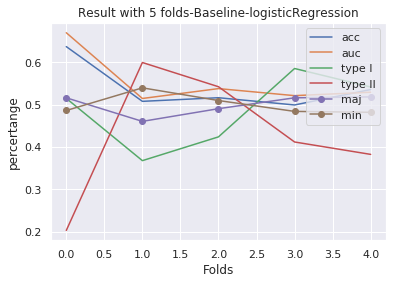

Mean : [0.5389136  0.55427915 0.486386   0.42751859]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


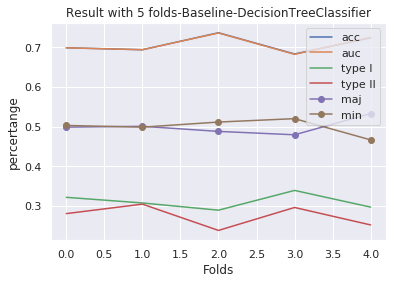

Mean : [0.70719541 0.70718154 0.31110577 0.27453114]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7919489741759549
Mean Accuracy[0.7991452991452992, 0.7987152034261242, 0.7944325481798715, 0.8008565310492506, 0.7665952890792291]
Mean Auc: 0.858473383509278
Mean Auc[0.8753812437220345, 0.8573054749752139, 0.8567550713473461, 0.8525528007346189, 0.8503723267671766]
Mean TypeII: 0.25661073628782927
Mean TypeII[0.24892703862660945, 0.252212389380531, 0.24786324786324787, 0.28512396694214875, 0.24892703862660945]
Mean TypeI: 0.15888479473736167
Mean TypeI[0.15319148936170213, 0.15352697095435686, 0.1630901287553648, 0.10666666666666667, 0.21794871794871795]
Mean Accuracy: 0.8035103131462875
Mean Accuracy[0.8034188034188035, 0.8115631691648822, 0.7815845824411135, 0.8179871520342612, 0.8029978586723768]
Mean Auc: 0.8759850760613215
Mean Auc[0.8744587155963303, 0.8879471656576775, 0.8572531715388858, 0.8900349328920757, 0.8702313946216386]
Mean TypeII: 0.2190713605569088
Mean TypeII[0.19724770642201836, 0.19831223628691982, 0.24774774774774774, 0.20408163265306123, 0.2479

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


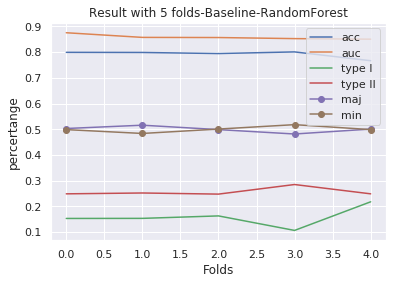

Mean : [0.79194897 0.85847338 0.15888479 0.25661074]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


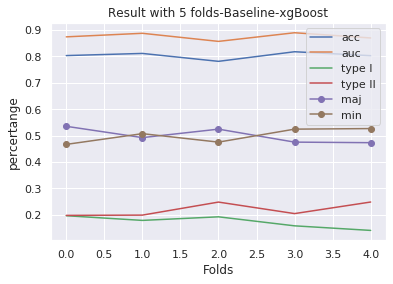

Mean : [0.80351031 0.87598508 0.17280535 0.21907136]
Mean Accuracy: 0.7748384853309908
Mean Accuracy[0.7521367521367521, 0.7687366167023555, 0.815845824411135, 0.7965738758029979, 0.7408993576017131]
Mean Auc: 0.840464516179485
Mean Auc[0.8304080216247809, 0.8236033160925865, 0.8619519354246927, 0.861280431829031, 0.8250788759263336]
Mean TypeII: 0.23541952038053013
Mean TypeII[0.2330508474576271, 0.21888412017167383, 0.20675105485232068, 0.2345132743362832, 0.2838983050847458]
Mean TypeI: 0.2150860871954578
Mean TypeI[0.2629310344827586, 0.24358974358974358, 0.1608695652173913, 0.17427385892116182, 0.23376623376623376]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


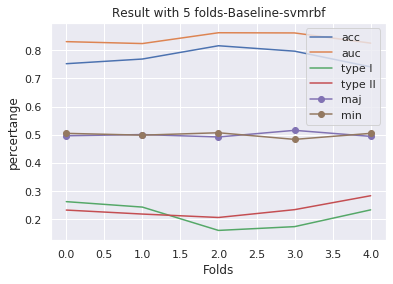

Mean : [0.77483849 0.84046452 0.21508609 0.23541952]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increas

Mean Accuracy: 0.5873103460897893
Mean Accuracy[0.6303418803418803, 0.5845824411134903, 0.5438972162740899, 0.5546038543897216, 0.6231263383297645]
Mean Auc: 0.6588812715685327
Mean Auc[0.7491217798594848, 0.6056382001836547, 0.6848856869808131, 0.6138215859030837, 0.6409391049156274]
Mean TypeII: 0.3800629827096517
Mean TypeII[0.09821428571428571, 0.21333333333333335, 0.7909836065573771, 0.5041666666666667, 0.2936170212765957]
Mean TypeI: 0.4312622302482132
Mean TypeI[0.6188524590163934, 0.6033057851239669, 0.08968609865470852, 0.3832599118942731, 0.46120689655172414]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


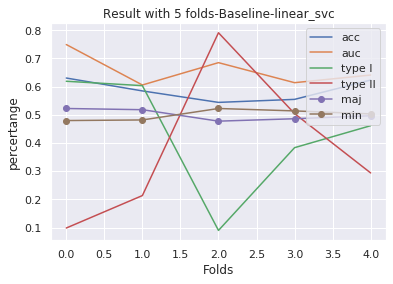

Mean : [0.58731035 0.65888127 0.43126223 0.38006298]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this

Mean Accuracy: 0.5372462892805505
Mean Accuracy[0.5299145299145299, 0.48822269807280516, 0.6252676659528907, 0.5331905781584583, 0.5096359743040685]
Mean Auc: 0.5341041503711351
Mean Auc[0.5021097046413502, 0.47709825528007344, 0.7366556534508076, 0.4524544953116381, 0.5022026431718062]
Mean TypeII: 0.37093479068306
Mean TypeII[0.5064935064935064, 0.4888888888888889, 0.1, 0.42448979591836733, 0.33480176211453744]
Mean TypeI: 0.5567737517513578
Mean TypeI[0.4345991561181435, 0.5330578512396694, 0.6651982378854625, 0.5135135135135135, 0.6375]


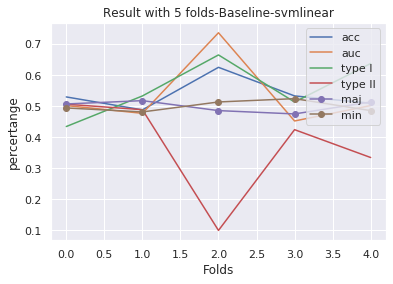

Mean : [0.53724629 0.53410415 0.55677375 0.37093479]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, incre

Mean Accuracy: 0.7731199326488406
Mean Accuracy[0.7649572649572649, 0.7665952890792291, 0.7708779443254818, 0.7858672376873662, 0.7773019271948608]
Mean Auc: 0.84463122423702
Mean Auc[0.8289379965299972, 0.8298530762167127, 0.8620923663842119, 0.8372336483231425, 0.8650390337310355]
Mean TypeII: 0.24842956237683378
Mean TypeII[0.22127659574468084, 0.28512396694214875, 0.2703862660944206, 0.24761904761904763, 0.21774193548387097]
Mean TypeI: 0.20596398694744886
Mean TypeI[0.24892703862660945, 0.17777777777777778, 0.18803418803418803, 0.1867704280155642, 0.228310502283105]


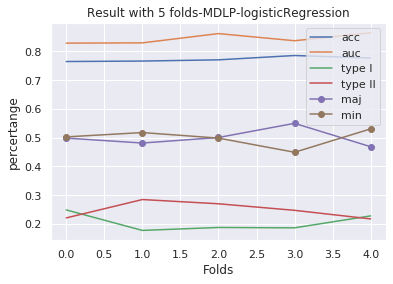

Categorical []
Mean Accuracy: 0.786395248814949
Mean Accuracy[0.7670940170940171, 0.7644539614561028, 0.8115631691648822, 0.7965738758029979, 0.7922912205567452]
Mean Auc: 0.8638244346602649
Mean Auc[0.8528983637971698, 0.8609643813506476, 0.8607188821474536, 0.8849059031096083, 0.8596346428964455]
Mean TypeII: 0.24592970299544534
Mean TypeII[0.23828125, 0.24786324786324787, 0.24774774774774774, 0.25112107623318386, 0.2446351931330472]
Mean TypeI: 0.18301223481396414
Mean TypeI[0.22641509433962265, 0.22317596566523606, 0.1346938775510204, 0.1598360655737705, 0.17094017094017094]
Mean Accuracy: 0.7136248833250975
Mean Accuracy[0.6858974358974359, 0.7130620985010707, 0.7430406852248393, 0.7002141327623126, 0.7259100642398287]
Mean Auc: 0.7226884868995167
Mean Auc[0.6845767509816454, 0.7208535420340976, 0.7618527760449157, 0.7065060908084165, 0.7396532746285085]
Mean TypeII: 0.30010982154360516
Mean TypeII[0.3562231759656652, 0.26785714285714285, 0.31004366812227074, 0.3055555555555556, 0

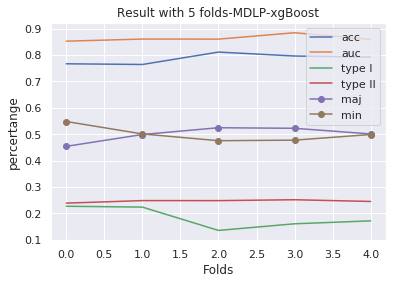

Categorical []


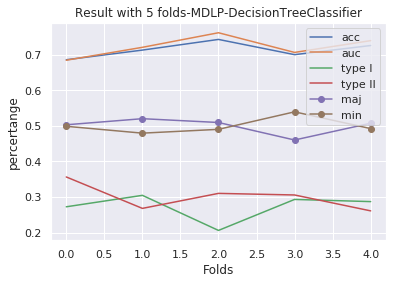

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.7555665367228537
Mean Accuracy[0.7521367521367521, 0.7730192719486081, 0.7794432548179872, 0.7473233404710921, 0.7259100642398287]
Mean Auc: 0.815333230629189
Mean Auc[0.8313749609855509, 0.8209422156790579, 0.838847994111152, 0.800477137909436, 0.7850238444607482]
Mean TypeII: 0.2608126931685908
Mean TypeII[0.25806451612903225, 0.2550607287449393, 0.25, 0.27710843373493976, 0.26382978723404255]
Mean TypeI: 0.22761675095678663
Mean TypeI[0.23904382470119523, 0.19545454545454546, 0.19433198380566802, 0.22477064220183487, 0.28448275862068967]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


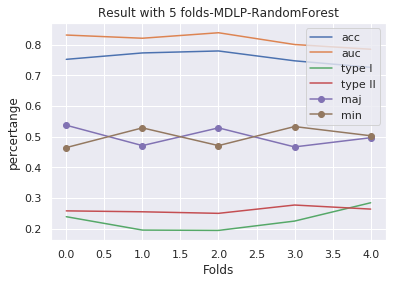

Categorical []
Mean Accuracy: 0.7795329343509215
Mean Accuracy[0.7905982905982906, 0.7473233404710921, 0.8072805139186295, 0.7751605995717344, 0.7773019271948608]
Mean Auc: 0.8463832506960062
Mean Auc[0.8343622150789012, 0.8144590031564265, 0.8711896115329593, 0.8702693268665491, 0.8416360968451944]
Mean TypeII: 0.26973614721233347
Mean TypeII[0.25, 0.301255230125523, 0.25213675213675213, 0.2857142857142857, 0.25957446808510637]
Mean TypeI: 0.17139483039256026
Mean TypeI[0.16810344827586207, 0.20175438596491227, 0.13304721030042918, 0.16872427983539096, 0.1853448275862069]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


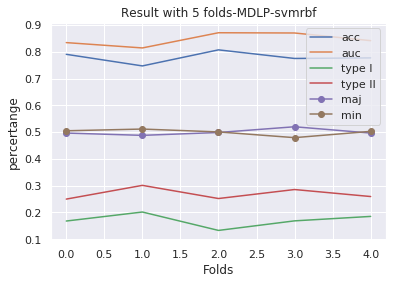

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7722542506268415
Mean Accuracy[0.7863247863247863, 0.7644539614561028, 0.7922912205567452, 0.7623126338329764, 0.7558886509635975]
Mean Auc: 0.8394734154389724
Mean Auc[0.8685479892565457, 0.8230189373046515, 0.8409282700421942, 0.8408865729697992, 0.8239853076216712]
Mean TypeII: 0.2425820664575303
Mean TypeII[0.23580786026200873, 0.20270270270270271, 0.26582278481012656, 0.2689075630252101, 0.2396694214876033]
Mean TypeI: 0.21194597844274826
Mean TypeI[0.19246861924686193, 0.2653061224489796, 0.14782608695652175, 0.2052401746724891, 0.24888888888888888]


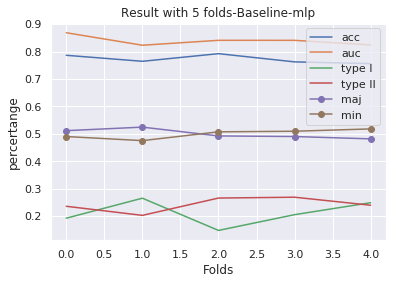

Mean : [0.77225425 0.83947342 0.21194598 0.24258207]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7726779406650927
Mean Accuracy[0.7970085470085471, 0.7708779443254818, 0.7665952890792291, 0.7473233404710921, 0.7815845824411135]
Mean Auc: 0.8448380557061743
Mean Auc[0.8615970835546926, 0.8400389476778364, 0.8499082905355833, 0.8331620857950167, 0.839483870967742]
Mean TypeII: 0.2618411379609127
Mean TypeII[0.22171945701357465, 0.2767857142857143, 0.25957446808510637, 0.31512605042016806, 0.236]
Mean TypeI: 0.19284923250298605
Mean TypeI[0.1862348178137652, 0.18518518518518517, 0.20689655172413793, 0.18777292576419213, 0.19815668202764977]


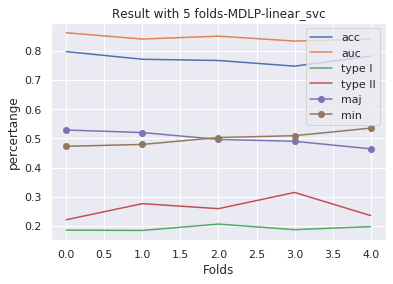

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.7654148135946851
Mean Accuracy[0.7564102564102564, 0.7687366167023555, 0.8094218415417559, 0.7537473233404711, 0.7387580299785867]
Mean Auc: 0.8239459951791976
Mean Auc[0.8115685271770894, 0.8333883872862071, 0.8573996624844082, 0.7791256770200067, 0.8382477219282775]
Mean TypeII: 0.2723767001266012
Mean TypeII[0.3103448275862069, 0.26778242677824265, 0.2245762711864407, 0.27522935779816515, 0.2839506172839506]
Mean TypeI: 0.1968566781346222
Mean TypeI[0.17796610169491525, 0.19298245614035087, 0.15584415584415584, 0.22088353413654618, 0.23660714285714285]


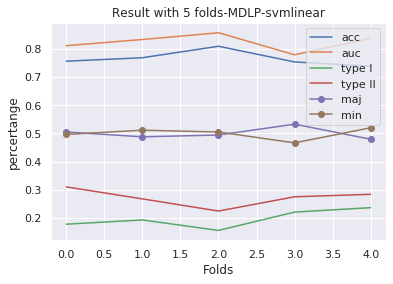

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, 

Mean Accuracy: 0.7825344534123977
Mean Accuracy[0.782051282051282, 0.7665952890792291, 0.7965738758029979, 0.8137044967880086, 0.7537473233404711]
Mean Auc: 0.8624992667432843
Mean Auc[0.8580254811998465, 0.8423789435069698, 0.8784527346759108, 0.8909024211298606, 0.8427367532038337]
Mean TypeII: 0.24389815555248112
Mean TypeII[0.21161825726141079, 0.2723404255319149, 0.21367521367521367, 0.17672413793103448, 0.34513274336283184]
Mean TypeI: 0.1922079639562659
Mean TypeI[0.22466960352422907, 0.1939655172413793, 0.19313304721030042, 0.19574468085106383, 0.15352697095435686]


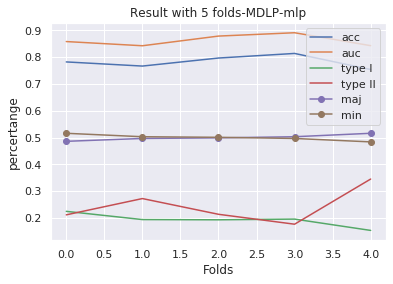

Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []
Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Categorical []
Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Categorical []
Categorical []


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7499853584436027
Mean Accuracy[0.7841880341880342, 0.728051391862955, 0.7366167023554604, 0.7944325481798715, 0.7066381156316917]
Mean Auc: 0.7629238032450247
Mean Auc[0.7966965704993514, 0.7403846153846154, 0.7722436250229316, 0.7943463484910054, 0.7109478568272204]
Mean TypeII: 0.2841868063384319
Mean TypeII[0.25523012552301255, 0.31363636363636366, 0.3037974683544304, 0.233201581027668, 0.3150684931506849]
Mean TypeI: 0.21566403558634262
Mean TypeI[0.17467248908296942, 0.23481781376518218, 0.2217391304347826, 0.17289719626168223, 0.27419354838709675]


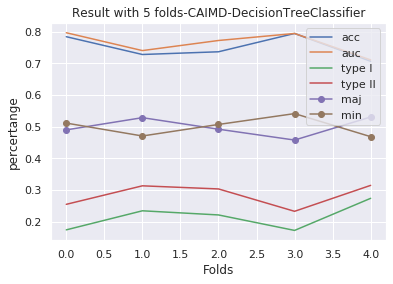

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Mean Accuracy: 0.7722460147513681
Mean Accuracy[0.8055555555555556, 0.7794432548179872, 0.7537473233404711, 0.7366167023554604, 0.7858672376873662]
Mean Auc: 0.846453384352644
Mean Auc[0.8814607771260999, 0.8515951351151527, 0.8360783952889218, 0.8021372225279765, 0.8609953917050692]
Mean TypeII: 0.2549248205518048
Mean TypeII[0.20161290322580644, 0.28169014084507044, 0.2681818181818182, 0.2911392405063291, 0.232]
Mean TypeI: 0.20214132370240384
Mean TypeI[0.18636363636363637, 0.16929133858267717, 0.22672064777327935, 0.23478260869565218, 0.1935483870967742]


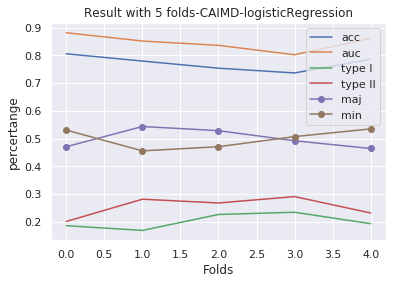

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Categorical []
Mean Accuracy: 0.746561979538425
Mean Accuracy[0.7777777777777778, 0.7473233404710921, 0.7130620985010707, 0.7516059957173448, 0.7430406852248393]
Mean Auc: 0.8165672661267216
Mean Auc[0.8393520636954334, 0.8141126957288833, 0.7874677953625322, 0.835337378194521, 0.8065663976522377]
Mean TypeII: 0.2806991607217867
Mean TypeII[0.24081632653061225, 0.29596412556053814, 0.33636363636363636, 0.23673469387755103, 0.2936170212765957]
Mean TypeI: 0.22778246065933955
Mean TypeI[0.20179372197309417, 0.21311475409836064, 0.242914979757085, 0.26126126126126126, 0.21982758620689655]


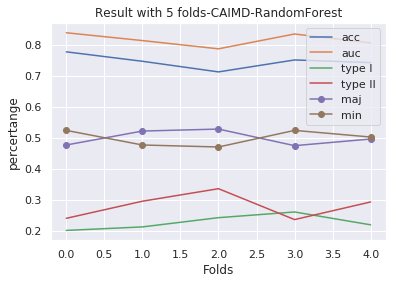

Mean Accuracy: 0.7885191895898533
Mean Accuracy[0.8076923076923077, 0.7751605995717344, 0.7580299785867237, 0.7815845824411135, 0.8201284796573876]
Mean Auc: 0.860576626975932
Mean Auc[0.865838736188476, 0.863820018365473, 0.8394368789105632, 0.8567351598173516, 0.8770523415977962]
Mean TypeII: 0.2418703047213992
Mean TypeII[0.2127659574468085, 0.2727272727272727, 0.2550607287449393, 0.2465753424657534, 0.2222222222222222]
Mean TypeI: 0.18126482704278382
Mean TypeI[0.17167381974248927, 0.17333333333333334, 0.22727272727272727, 0.1935483870967742, 0.14049586776859505]


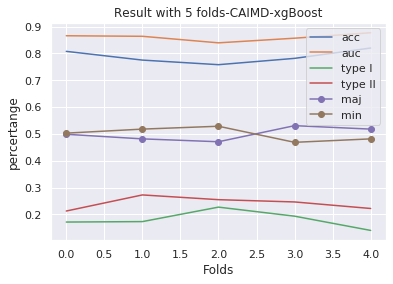

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.7880918391625029
Mean Accuracy[0.8055555555555556, 0.7623126338329764, 0.7708779443254818, 0.7987152034261242, 0.8029978586723768]
Mean Auc: 0.8516860592780553
Mean Auc[0.8912455203686098, 0.8229434683525694, 0.8389959618208517, 0.8569390402075228, 0.8483063056407225]
Mean TypeII: 0.2555026314781894
Mean TypeII[0.2231404958677686, 0.27802690582959644, 0.2916666666666667, 0.22380952380952382, 0.2608695652173913]
Mean TypeI: 0.16638135710776128
Mean TypeI[0.16371681415929204, 0.20081967213114754, 0.16299559471365638, 0.1828793774319066, 0.12149532710280374]


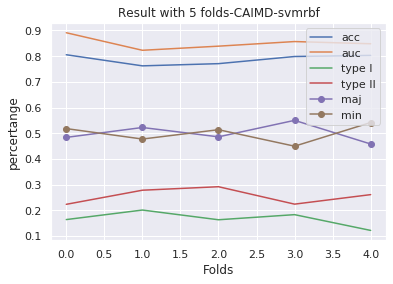

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.7649819725836856
Mean Accuracy[0.7670940170940171, 0.7451820128479657, 0.7837259100642399, 0.7730192719486081, 0.7558886509635975]
Mean Auc: 0.8350286502993507
Mean Auc[0.8351769911504425, 0.8077290953905014, 0.850108225108225, 0.8556383251990752, 0.8264906146485094]
Mean TypeII: 0.2592154605347677
Mean TypeII[0.24336283185840707, 0.31221719457013575, 0.2669491525423729, 0.2184873949579832, 0.2550607287449393]
Mean TypeI: 0.21170414699408976
Mean TypeI[0.2231404958677686, 0.2032520325203252, 0.1645021645021645, 0.23580786026200873, 0.2318181818181818]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


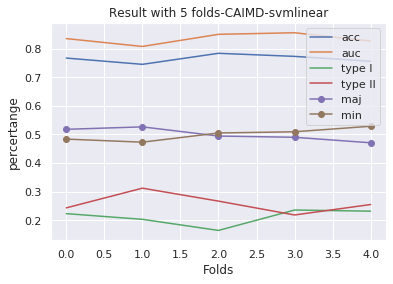

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.7752457036182946
Mean Accuracy[0.8012820512820513, 0.7580299785867237, 0.7494646680942184, 0.7644539614561028, 0.8029978586723768]
Mean Auc: 0.8496240914282793
Mean Auc[0.8702369633584436, 0.8343520558002937, 0.8221275658208791, 0.8422491286002568, 0.8791547435615232]
Mean TypeII: 0.26597101271652923
Mean TypeII[0.24778761061946902, 0.275, 0.2863070539419087, 0.2956521739130435, 0.22510822510822512]
Mean TypeI: 0.18380742319227417
Mean TypeI[0.15289256198347106, 0.20704845814977973, 0.21238938053097345, 0.17721518987341772, 0.1694915254237288]


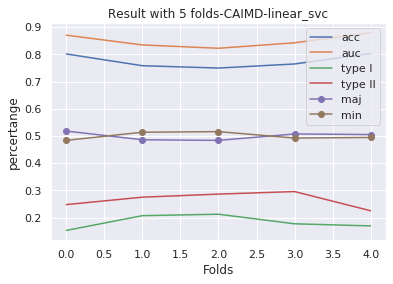

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.7838091839162503
Mean Accuracy[0.8055555555555556, 0.7987152034261242, 0.7537473233404711, 0.7751605995717344, 0.7858672376873662]
Mean Auc: 0.8593632761655137
Mean Auc[0.8807291666666667, 0.8670169839697737, 0.8431412188487832, 0.8478675768920207, 0.8580614344503235]
Mean TypeII: 0.2509213671794823
Mean TypeII[0.20175438596491227, 0.24892703862660945, 0.22950819672131148, 0.28870292887029286, 0.2857142857142857]
Mean TypeI: 0.1823926059735595
Mean TypeI[0.1875, 0.15384615384615385, 0.2645739910313901, 0.15789473684210525, 0.14814814814814814]


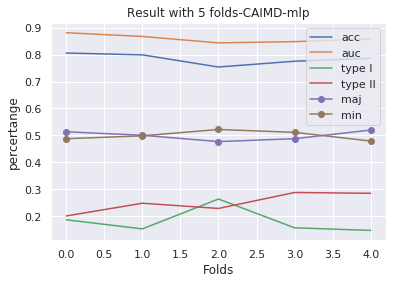

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Lab-722\Anaco

Mean Accuracy: 0.5407053569794469
Mean Accuracy[0.452991452991453, 0.5139186295503212, 0.5032119914346895, 0.588865096359743, 0.6445396145610278]
Mean Auc: 0.5491666415795529
Mean Auc[0.4356032092826849, 0.5291840927434148, 0.4965973292244479, 0.6056151210345971, 0.6788334556126193]
Mean TypeII: 0.5236629993082567
Mean TypeII[0.5577689243027888, 0.7245762711864406, 0.6147186147186147, 0.38073394495412843, 0.34051724137931033]
Mean TypeI: 0.39326123131654206
Mean TypeI[0.5345622119815668, 0.24242424242424243, 0.3813559322033898, 0.43775100401606426, 0.3702127659574468]


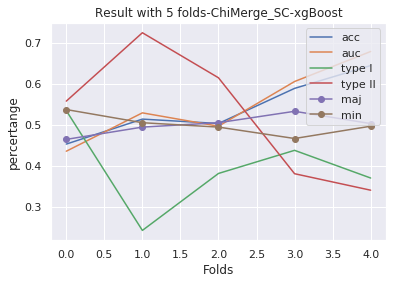

Compare Result-USA_Bankrupt-xgBoost


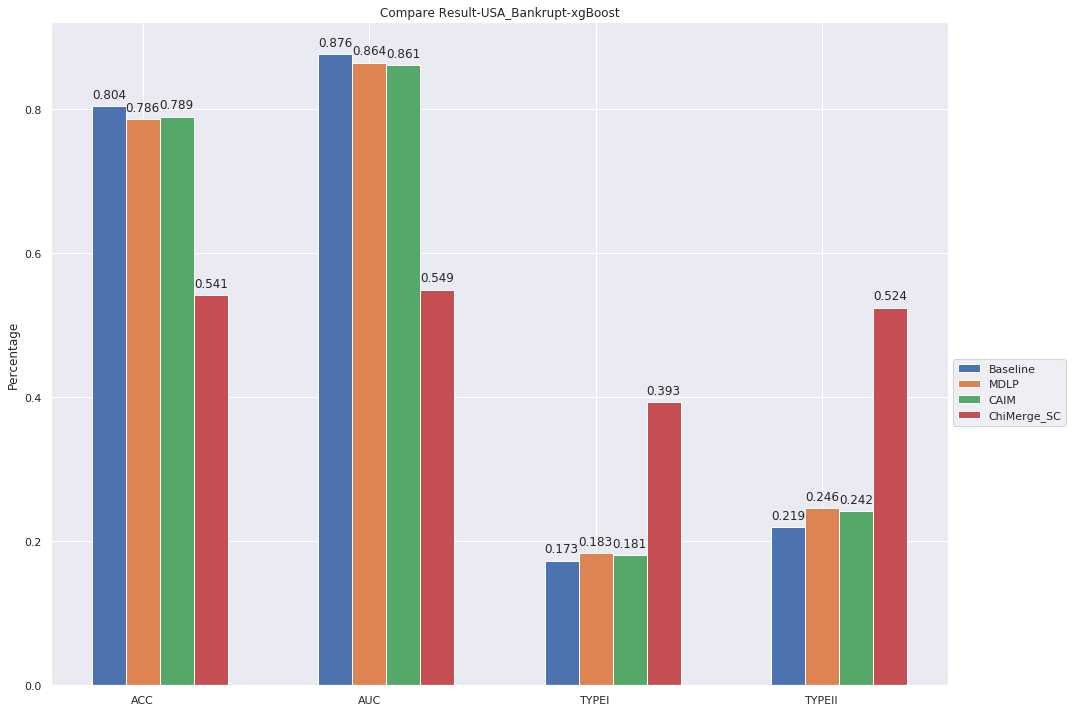

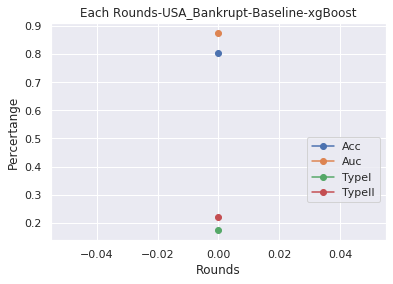

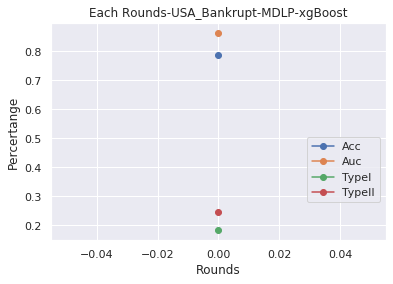

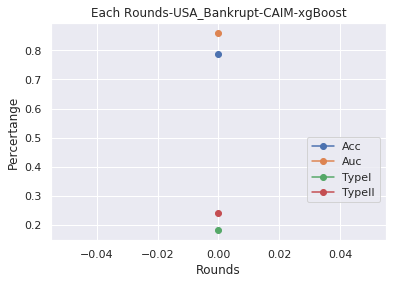

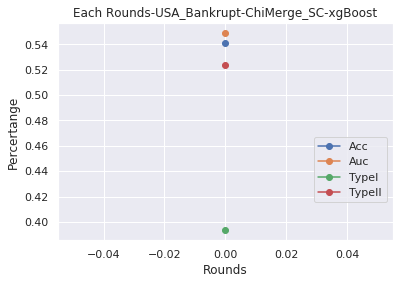

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.80 0.88   0.17    0.22          2.36
MDLP          0.79 0.86   0.18    0.25         60.08
CAIM          0.79 0.86   0.18    0.24        251.03
ChiMerge      0.54 0.55   0.39    0.52        731.52


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Mean Accuracy: 0.498286937901499
Mean Accuracy[0.5, 0.44539614561027835, 0.5160599571734475, 0.5417558886509636, 0.48822269807280516]
Mean Auc: 0.5532974055932882
Mean Auc[0.5759891757478242, 0.5825080672081897, 0.5281050429420832, 0.5876559060895085, 0.49222883597883604]
Mean TypeII: 0.2651034132282328
Mean TypeII[0.05752212389380531, 0.9767441860465116, 0.017543859649122806, 0.08620689655172414, 0.1875]
Mean TypeI: 0.7023635519440775
Mean TypeI[0.9132231404958677, 0.03349282296650718, 0.9288702928870293, 0.825531914893617, 0.8106995884773662]


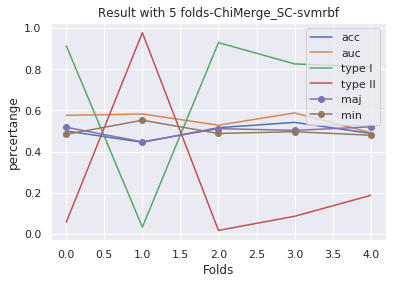

Compare Result-USA_Bankrupt-svmrbf


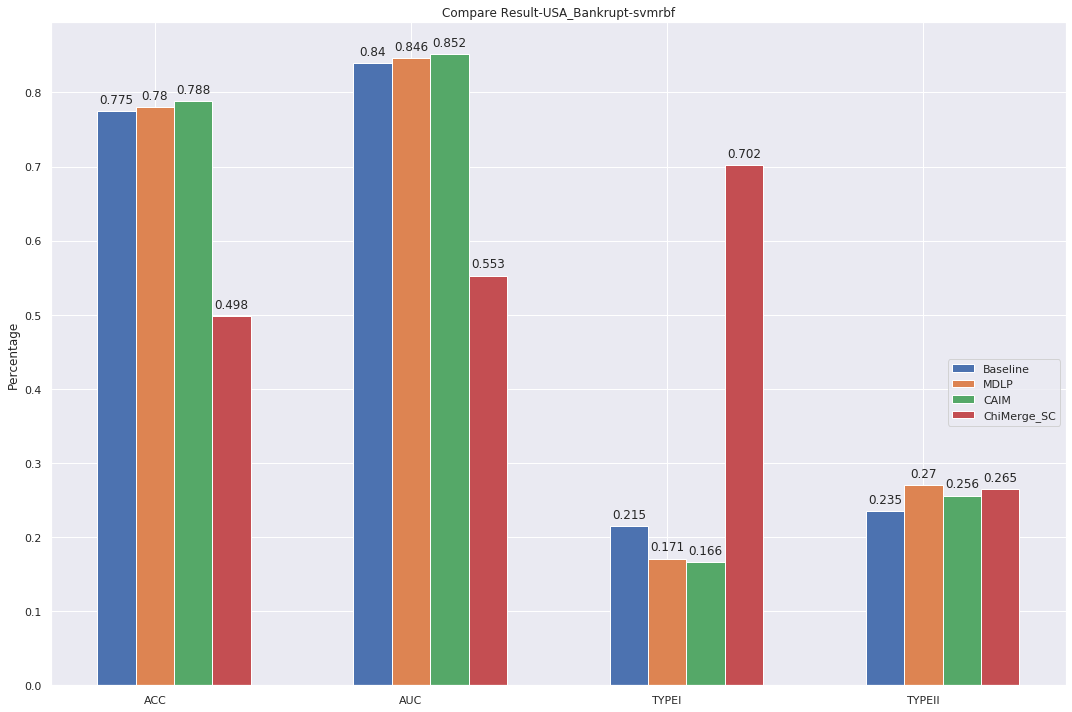

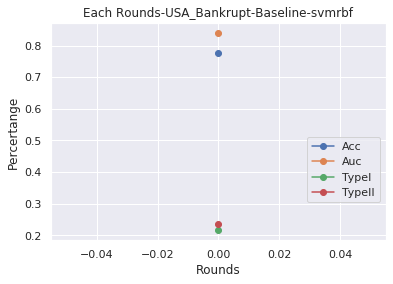

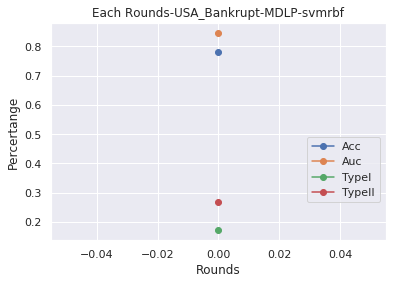

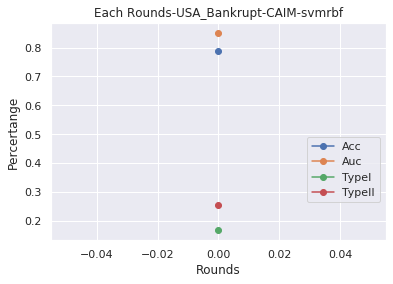

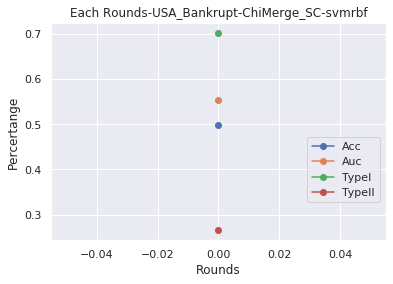

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.77 0.84   0.22    0.24          3.42
MDLP          0.78 0.85   0.17    0.27         64.19
CAIM          0.79 0.85   0.17    0.26        247.47
ChiMerge      0.50 0.55   0.70    0.27        751.43


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Mean Accuracy: 0.5727859221435239
Mean Accuracy[0.5448717948717948, 0.5588865096359743, 0.5653104925053534, 0.5139186295503212, 0.6809421841541756]
Mean Auc: 0.5913075525797489
Mean Auc[0.557309076296418, 0.5662557781201849, 0.5767661545247372, 0.5137574290116662, 0.7424493249457381]
Mean TypeII: 0.48485106799761296
Mean TypeII[0.6371308016877637, 0.47186147186147187, 0.5605381165919282, 0.5108225108225108, 0.24390243902439024]
Mean TypeI: 0.3727333375209419
Mean TypeI[0.2683982683982684, 0.4110169491525424, 0.319672131147541, 0.461864406779661, 0.40271493212669685]


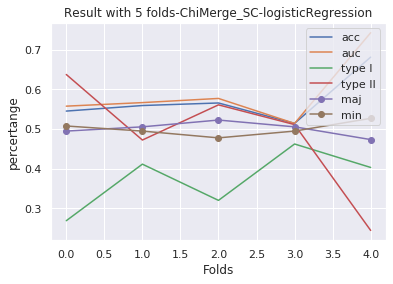

Compare Result-USA_Bankrupt-logisticRegression


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


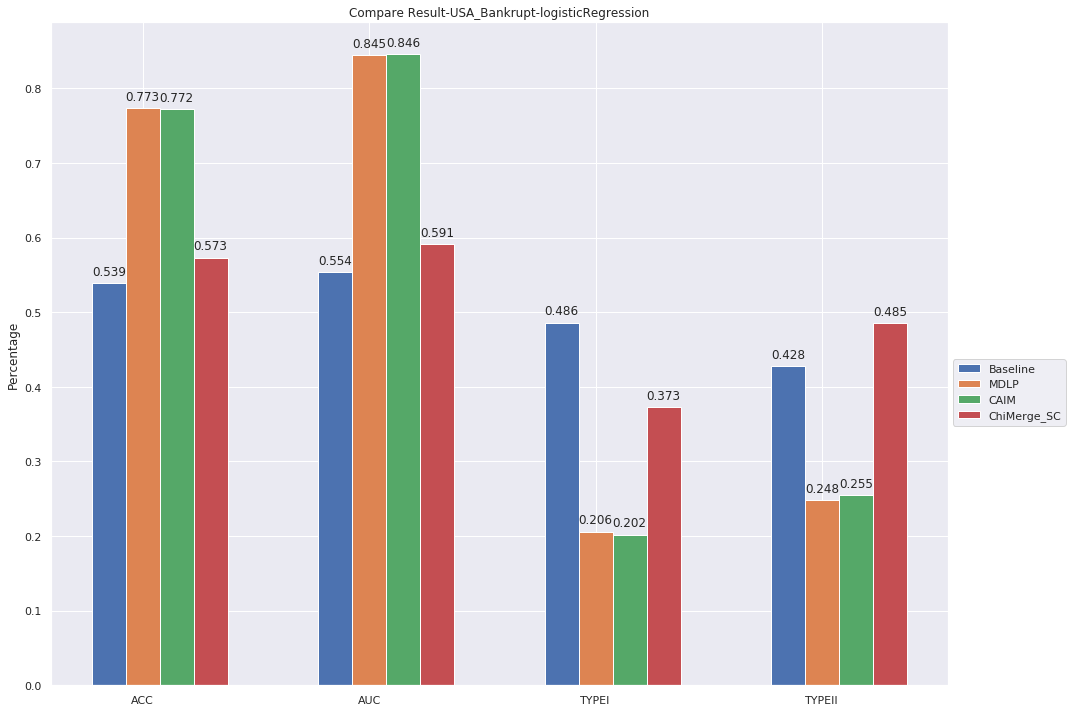

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


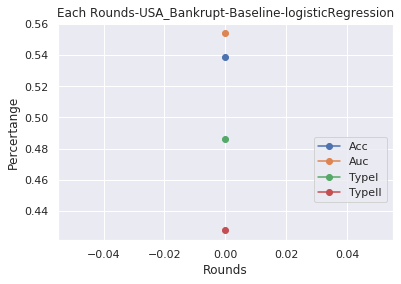

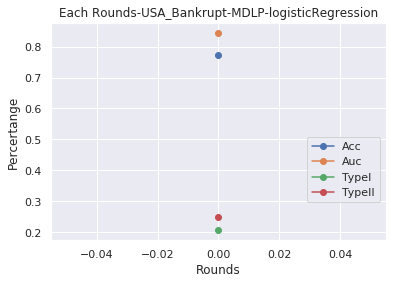

C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Mean Accuracy: 0.5787285638463369
Mean Accuracy[0.6688034188034188, 0.5267665952890792, 0.6509635974304069, 0.42398286937901497, 0.6231263383297645]
Mean Auc: 0.5998681469625909
Mean Auc[0.6881380695826864, 0.5495597945707997, 0.6902521502609718, 0.41875527503577853, 0.6526354453627181]
Mean TypeII: 0.45392431665531746
Mean TypeII[0.24892703862660945, 0.6206896551724138, 0.26905829596412556, 0.6722689075630253, 0.45867768595041325]
Mean TypeI: 0.38548562021917154
Mean TypeI[0.4127659574468085, 0.3276595744680851, 0.42213114754098363, 0.4759825327510917, 0.28888888888888886]


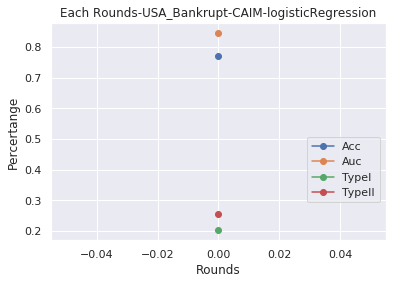

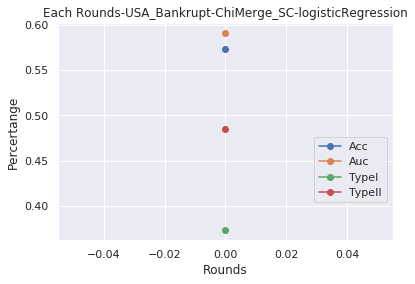

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.54 0.55   0.49    0.43          0.56
MDLP          0.77 0.84   0.21    0.25         60.07
CAIM          0.77 0.85   0.20    0.25        242.52
ChiMerge      0.57 0.59   0.37    0.48        766.88


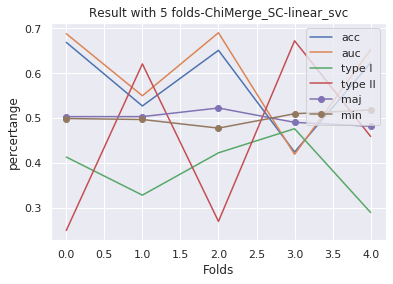

Compare Result-USA_Bankrupt-linear_svc


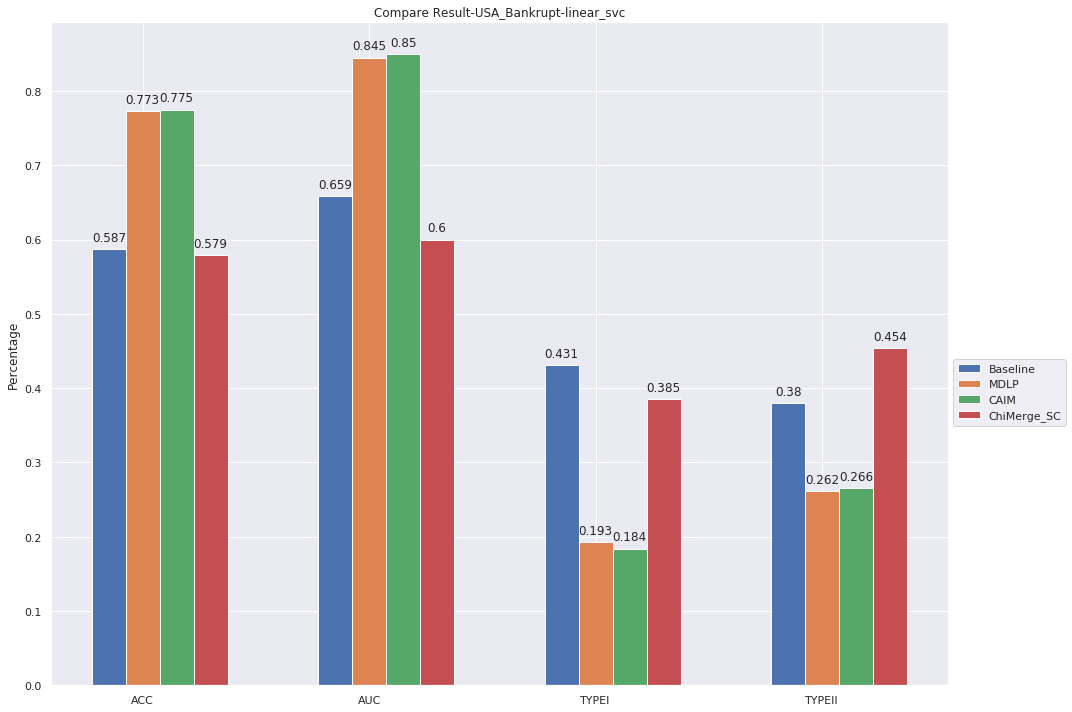

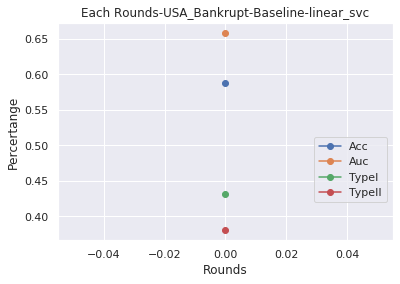

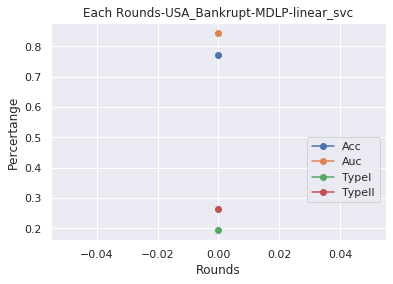

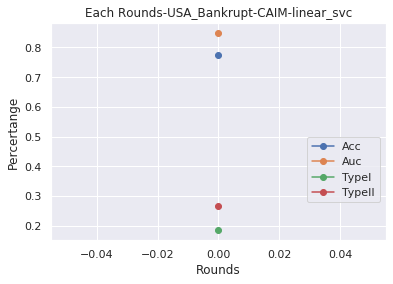

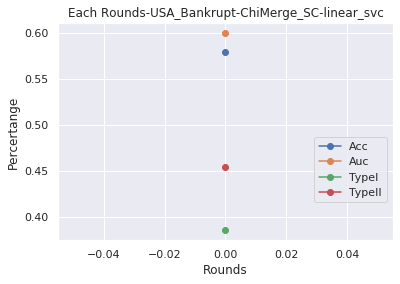

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.59 0.66   0.43    0.38         11.64
MDLP          0.77 0.84   0.19    0.26         63.30
CAIM          0.78 0.85   0.18    0.27        250.45
ChiMerge      0.58 0.60   0.39    0.45        746.62
Mean Accuracy: 0.5154367759292813
Mean Accuracy[0.4551282051282051, 0.4518201284796574, 0.5717344753747323, 0.5267665952890792, 0.5717344753747323]
Mean Auc: 0.5289351997226351
Mean Auc[0.45509715392911326, 0.4301348967139602, 0.5944644233239147, 0.5404306220095695, 0.624548902636618]
Mean TypeII: 0.5100365877269605
Mean TypeII[0.5682819383259912, 0.6352459016393442, 0.33624454148471616, 0.41363636363636364, 0.5967741935483871]
Mean TypeI: 0.4512603619013905
Mean TypeI[0.5228215767634855, 0.452914798206278, 0.5168067226890757, 0.5263157894736842, 0.2374429223744292]


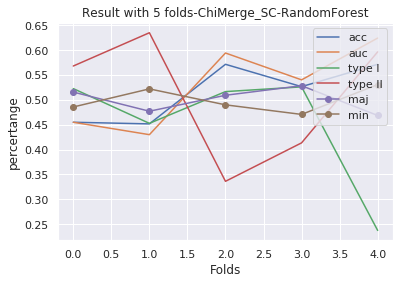

Compare Result-USA_Bankrupt-RandomForest


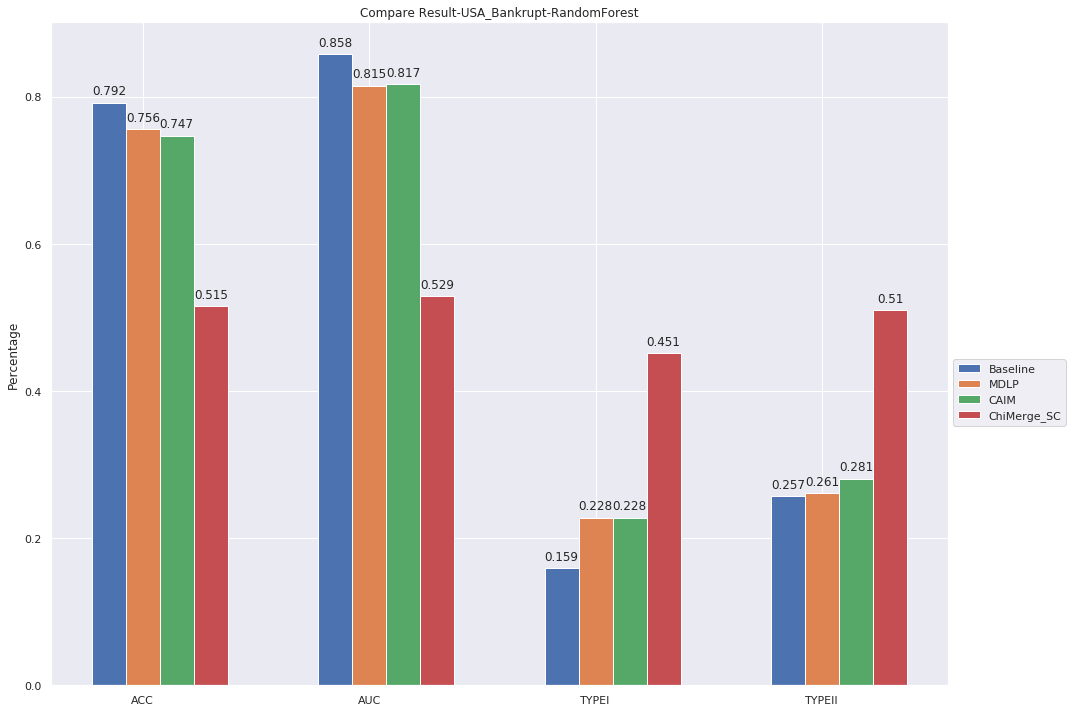

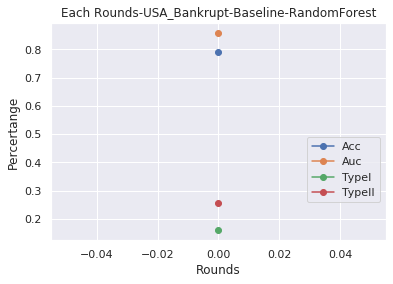

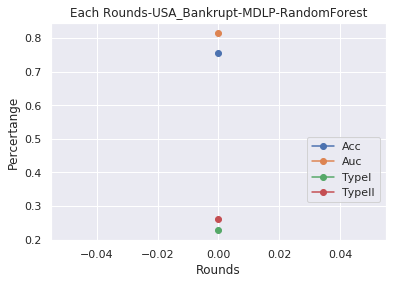

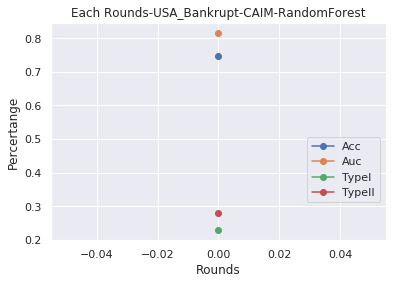

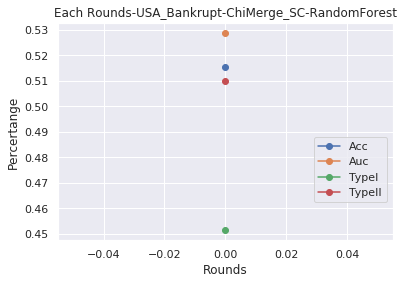

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.79 0.86   0.16    0.26          1.81
MDLP          0.76 0.82   0.23    0.26         65.03
CAIM          0.75 0.82   0.23    0.28        245.19
ChiMerge      0.52 0.53   0.45    0.51        778.63
Mean Accuracy: 0.49961016856091794
Mean Accuracy[0.41025641025641024, 0.47751605995717344, 0.5331905781584583, 0.5717344753747323, 0.5053533190578159]
Mean Auc: 0.5009363633606736
Mean Auc[0.41071787469624166, 0.4783362695441533, 0.5334361007120311, 0.5716345270890725, 0.5105570447618698]
Mean TypeII: 0.5175480325056843
Mean TypeII[0.5676855895196506, 0.4868421052631579, 0.45614035087719296, 0.4256198347107438, 0.6514522821576764]
Mean TypeI: 0.4805792407729683
Mean TypeI[0.6108786610878661, 0.5564853556485355, 0.4769874476987448, 0.4311111111111111, 0.3274336283185841]


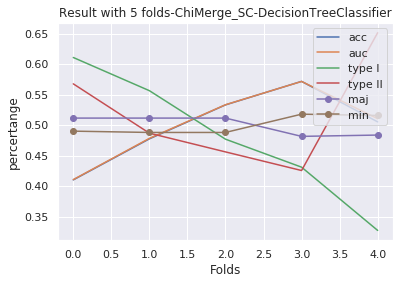

Compare Result-USA_Bankrupt-DecisionTreeClassifier
Mean Accuracy: 0.524435842530061
Mean Accuracy[0.4423076923076923, 0.5182012847965739, 0.5374732334047109, 0.6295503211991434, 0.49464668094218417]
Mean Auc: 0.5367189513380186
Mean Auc[0.4302218455188679, 0.5261024286448015, 0.5444107929515418, 0.6969602293611703, 0.4858994602137113]
Mean TypeII: 0.47880046397980297
Mean TypeII[0.5283018867924528, 0.3722943722943723, 0.3125, 0.4672131147540984, 0.7136929460580913]
Mean TypeI: 0.46798390140723034
Mean TypeI[0.58203125, 0.5889830508474576, 0.6211453744493393, 0.2645739910313901, 0.2831858407079646]


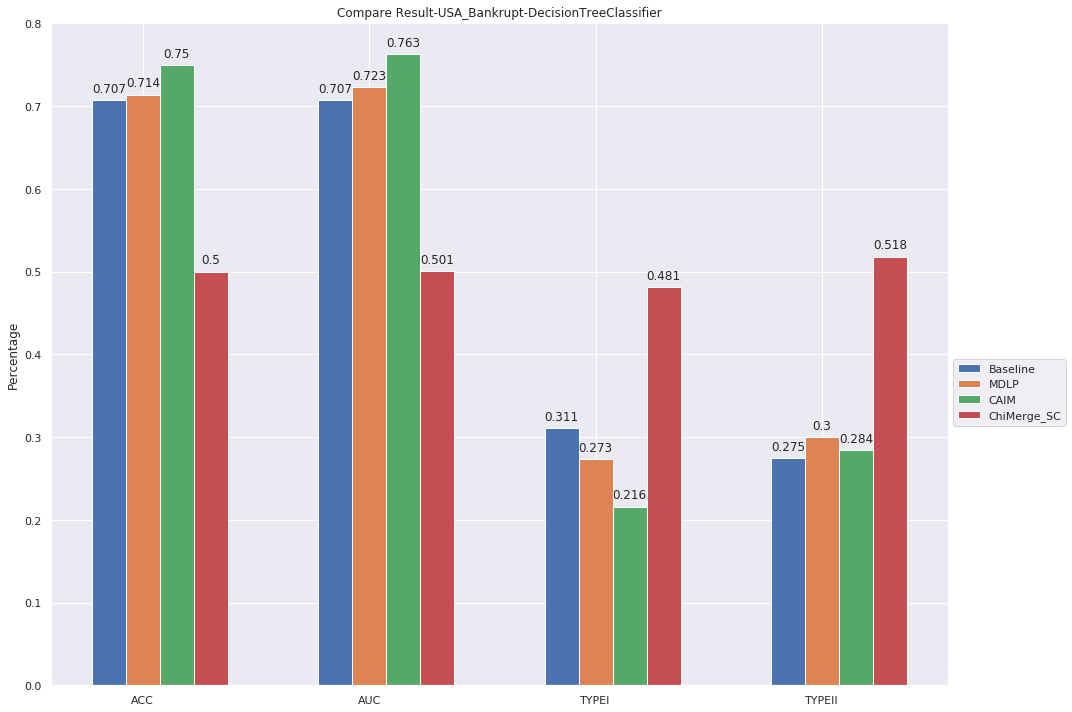

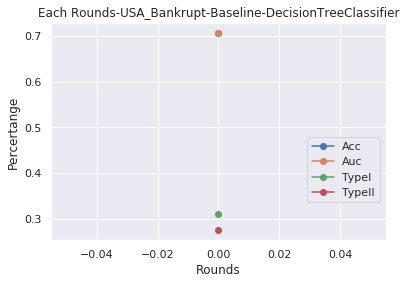

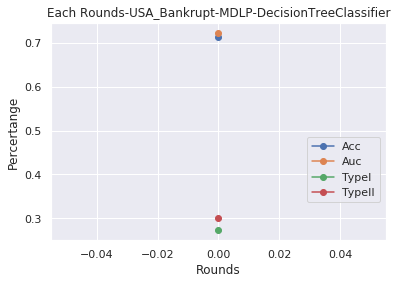

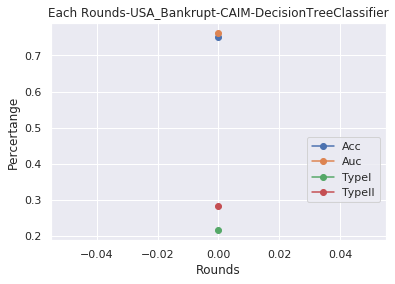

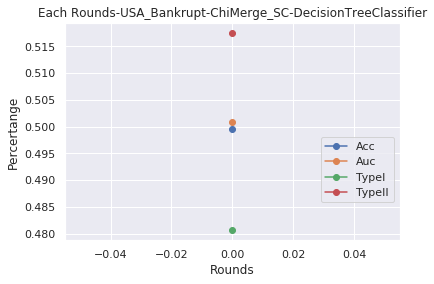

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.71 0.71   0.31    0.27          0.96
MDLP          0.71 0.72   0.27    0.30         62.24
CAIM          0.75 0.76   0.22    0.28        234.96
ChiMerge      0.50 0.50   0.48    0.52        798.60


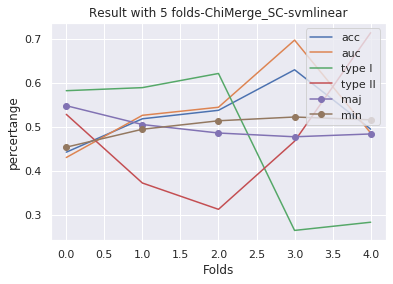

Compare Result-USA_Bankrupt-svmlinear


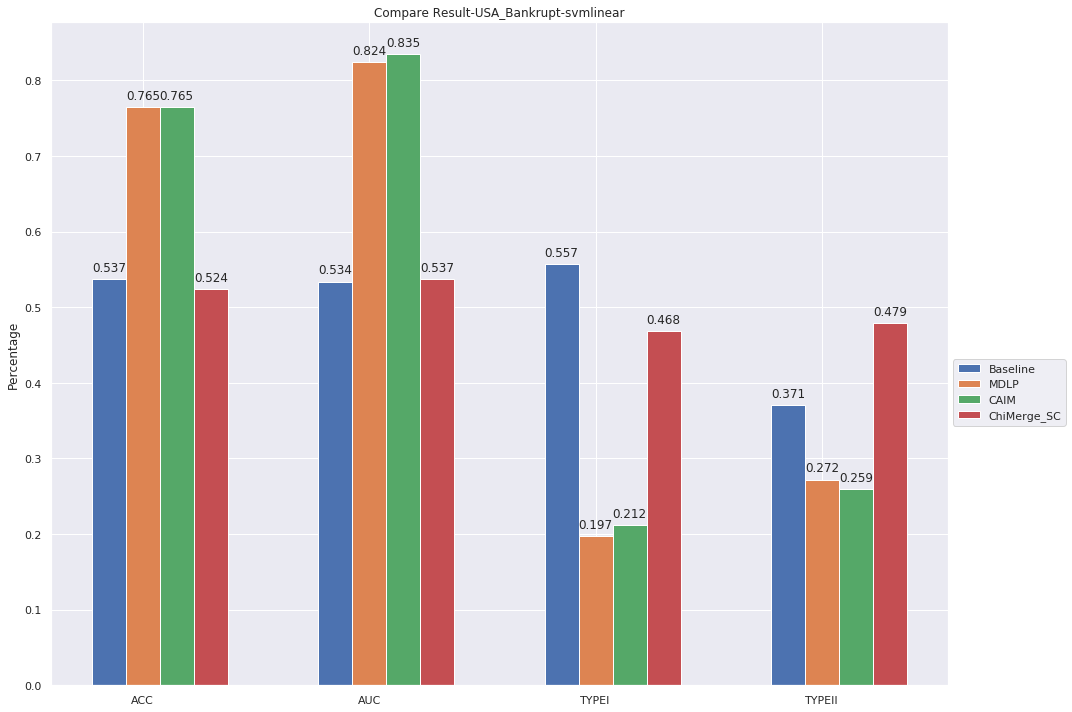

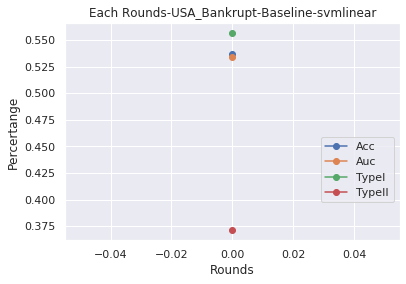

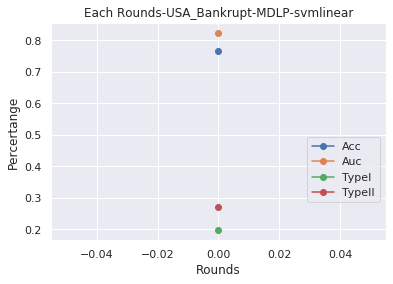

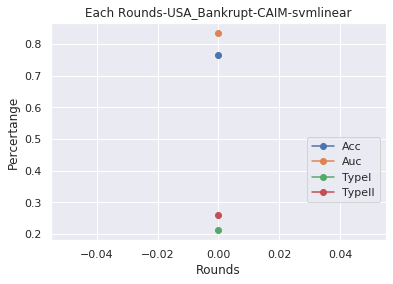

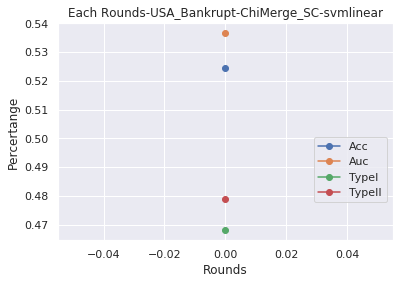

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.54 0.53   0.56    0.37         33.15
MDLP          0.77 0.82   0.20    0.27         51.22
CAIM          0.76 0.84   0.21    0.26        239.93
ChiMerge      0.52 0.54   0.47    0.48        774.12


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Mean Accuracy: 0.5385063782280056
Mean Accuracy[0.5876068376068376, 0.5974304068522484, 0.5674518201284796, 0.4753747323340471, 0.46466809421841543]
Mean Auc: 0.5603825544318551
Mean Auc[0.632877162851035, 0.6237796373779636, 0.6201116292733082, 0.45052542621987063, 0.4746189164370982]
Mean TypeII: 0.4342674232760871
Mean TypeII[0.3318777292576419, 0.39473684210526316, 0.4424778761061947, 0.4567901234567901, 0.5454545454545454]
Mean TypeI: 0.4890953669279421
Mean TypeI[0.4895397489539749, 0.4100418410041841, 0.42323651452282157, 0.5982142857142857, 0.5244444444444445]


C:\Users\Lab-722\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


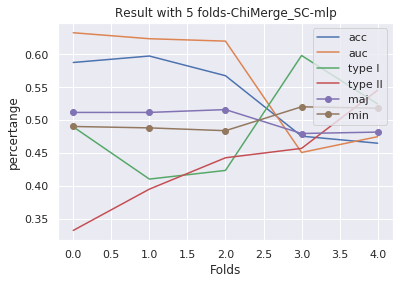

Compare Result-USA_Bankrupt-mlp


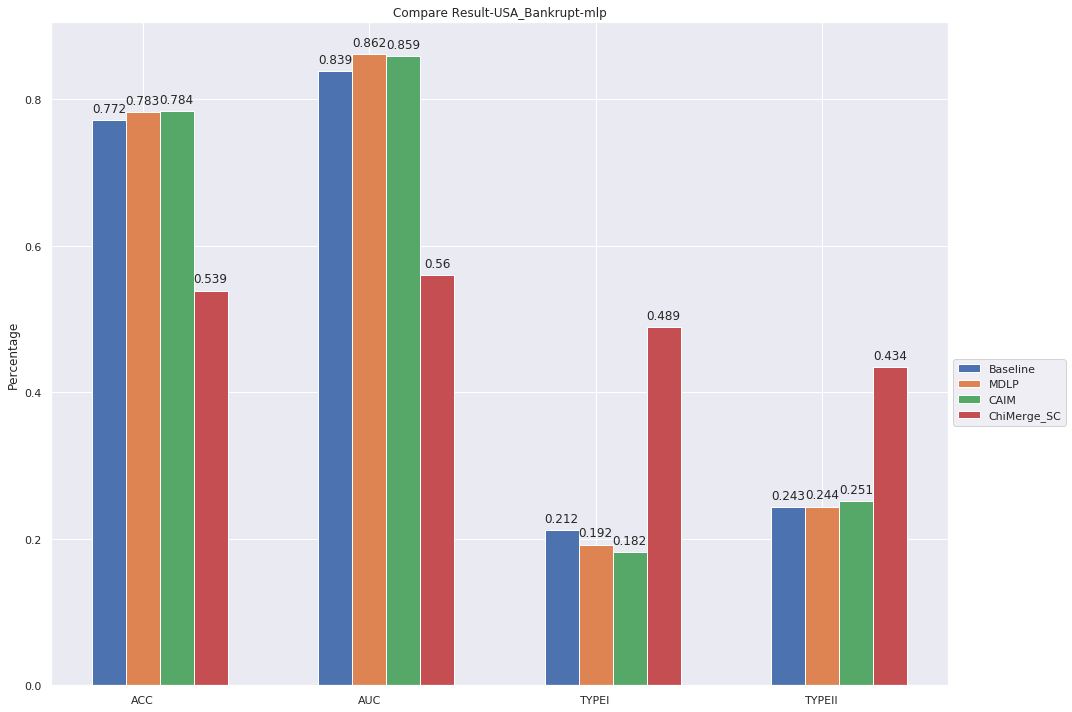

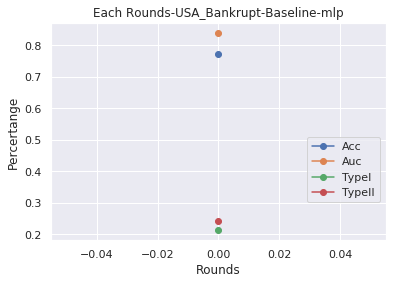

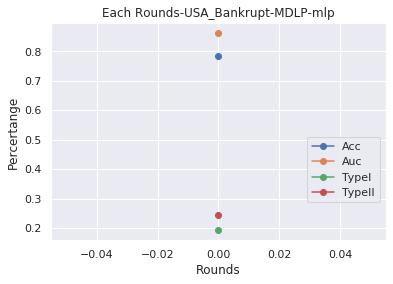

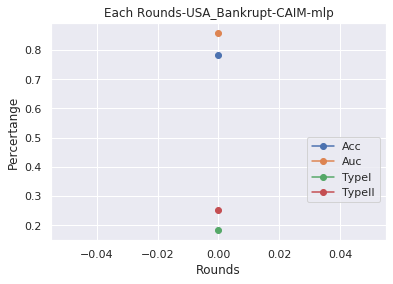

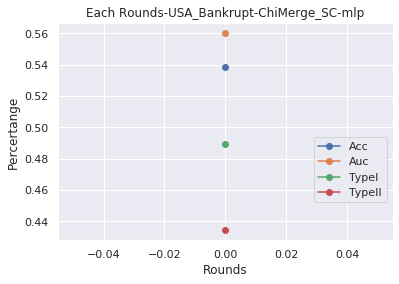

          Accuracy  AUC  TypeI  TypeII  Time(Second)
Baseline      0.77 0.84   0.21    0.24         69.41
MDLP          0.78 0.86   0.19    0.24         47.73
CAIM          0.78 0.86   0.18    0.25        285.28
ChiMerge      0.54 0.56   0.49    0.43        707.22

程式結束
Wall time: 18min 30s


In [11]:
%%time

# Classifcation Method
linear_svc = CalibratedClassifierCV(LinearSVC(max_iter=7000))
svmlinear = SVC(kernel='linear', probability=True)
svmrbf = SVC(kernel='rbf', probability=True)
DecisionTreeClassifier = tree.DecisionTreeClassifier()
RandomForest = RandomForestClassifier()
logisticRegression = LogisticRegression()
mlp = MLPClassifier()
xgBoost = xgb.XGBClassifier()

##########################################
#svmpoly = SVC(kernel='poly', probability=True)
#neigh = KNeighborsRegressor(n_neighbors=5)
#linearRegression= LinearRegression()

#DecisionTreeClassifier,logisticRegression,mlp,xgBoost
# classifier_list = [svmrbf,DecisionTreeClassifier,RandomForest,logisticRegression,mlp,xgBoost ]
# classifier_name_list = ['svmrbf','DecisionTreeClassifier','RandomForest','LogisticRegression','MLPClassifier','xgBoost' ]
def run10times(classifier_list,classifier_name_list):

    classifier_list = [classifier_list]
    classifier_name_list = [classifier_name_list]
        
    classifier_result_list = []



    for idx,classifi in enumerate(classifier_list):

        result_list = []
        rounds = 2
        clf_name = classifier_name_list[idx]
        for i in range(1,rounds):

            result_list.clear()
            result_10times_baseline = []
            result_10times_MDLP = []
            result_10times_CAIM = []
            result_10times_ChiMerge_SC = []
            result_10times_ChiMerge_RG = []
            runnung_time_list = []
            #Method Select

            clf = classifi
            fold = 5

            start_time = time.time()
            result_eachtimes_baseline = KFoldFuntion(clf, clf_name, 'Baseline', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_baseline.append(result_eachtimes_baseline)
            print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0)))
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_MDLP = KFoldFuntion(clf, clf_name, 'MDLP', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_MDLP.append(result_eachtimes_MDLP)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_CAIM = KFoldFuntion(clf, clf_name, 'CAIMD', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_CAIM.append(result_eachtimes_CAIM)
            runnung_time_list.append(time.time() - start_time)

            start_time = time.time()
            result_eachtimes_ChiMerge_SC = KFoldFuntion(clf, clf_name, 'ChiMerge_SC', data_list, target_list, fold, discretize_coloumn).Classify()
            result_10times_ChiMerge_SC.append(result_eachtimes_ChiMerge_SC)
            runnung_time_list.append(time.time() - start_time)
    
        
        # Thread Lock
        lock.acquire()
        
        
        # Compare Chart (Same Classifier)
        CompareMethodMeanResult(data_name, clf_name, rounds,result_10times_baseline,result_10times_MDLP,result_10times_CAIM,result_10times_ChiMerge_SC)


        # Compare Chart (Same Classifier)
        ResultEachMethodLineChart(result_10times_baseline,"Baseline",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_MDLP,"MDLP",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_CAIM,"CAIM",data_name,clf_name)
        ResultEachMethodLineChart(result_10times_ChiMerge_SC,"ChiMerge_SC",data_name,clf_name)

        result_list.append(np.mean(result_10times_baseline, axis=0))
        result_list.append(np.mean(result_10times_MDLP, axis=0))
        result_list.append(np.mean(result_10times_CAIM, axis=0))
        result_list.append(np.mean(result_10times_ChiMerge_SC, axis=0))

        # Single Classify Method 
        result_with_method = pd.DataFrame(result_list, index=['Baseline','MDLP','CAIM','ChiMerge'], columns=['Accuracy','AUC','TypeI','TypeII'])
        result_with_method['Time(Second)'] = runnung_time_list
        print(result_with_method)

        file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
        file_name = "Classifier_result_list_{fold}Fold_{data_name}_{method}_{file_timeA}.xlsx".format(fold = fold, file_timeA = file_time,data_name=data_name,method=clf_name)
        pd.DataFrame(result_with_method).to_excel(file_name)
        
        
        # Thread Unlock
        lock.release()
    
lock = Lock()

t0 = Thread(target=run10times,args=(svmlinear,"svmlinear"))
t1 = Thread(target=run10times,args=(linear_svc,"linear_svc"))
t2 = Thread(target=run10times,args=(svmrbf,"svmrbf"))
t3 = Thread(target=run10times,args=(DecisionTreeClassifier,"DecisionTreeClassifier"))
t4 = Thread(target=run10times,args=(RandomForest,"RandomForest"))
t5 = Thread(target=run10times,args=(logisticRegression,"logisticRegression"))
t6 = Thread(target=run10times,args=(mlp,"mlp"))
t7 = Thread(target=run10times,args=(xgBoost,"xgBoost"))

thread_list = [t0,t1,t2,t3,t4,t5,t6,t7]
#thread_list = [t3,t4,t5,t7]

#程式開始
for item in thread_list:
    item.start()
print("\n程式開始")


#程式結束
for item in thread_list:
    item.join()
print("\n程式結束")
    


#############################################################################YEE

## Record Result

title = 'Compare Result-{data_name}-{classifier_name}'.format(data_name=data_name,classifier_name=clf_name)
with pd.ExcelWriter('output.xlsx') as writer:  # doctest: +SKIP
        df1.to_excel(writer, sheet_name='Sheet_name_1')
        df2.to_excel(writer, sheet_name='Sheet_name_2')

file_time = time.strftime("%Y-%m-%d-%H%M%S", time.localtime()) 
file_name = "result_10times_baseline_{file_timeA}.xlsx".format(file_timeA = file_time)
pd.DataFrame(result_10times_baseline).to_excel(file_name, header=False, index=False)

## Compare result

print("Mean : {0}".format(np.mean(result_10times_baseline, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_MDLP, axis=0))) 

print("Mean : {0}".format(np.mean(result_10times_CAIM, axis=0)))

print("Mean : {0}".format(np.mean(result_10times_ChiMerge_SC, axis=0)))

In [12]:

#ResultEachMethodLineChart(result_10times_ChiMerge_RG,"ChiMerge_RG",data_name,clf_name)